In [1]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from functools import reduce
import operator 

### Create basic hex board
This hexboard implementation is not my own and is the work of Justin Yang, my implementation was a Cyclic graph, the problems with which I have outlined in my paper. As this is collaboration between the two of us we included the working version of the encoding.

In [2]:
inds = np.array([                                                        [0,8], [0,9], [0,10],
                                                                  [1,7],               [1,10],
                                             [2,4], [2,5], [2,6],        [2,8],        [2,10], [2,11], [2,12],
                                      [3,3],               [3,6],               [3,9],                 [3,12],
                               [4,2],        [4,4],        [4,6], [4,7], [4,8],        [4,10],         [4,12], 
                               [5,2],               [5,5],               [5,8],                [5,11], 
                               [6,2], [6,3], [6,4],        [6,6],        [6,8], [6,9], [6,10], 
                        [7,1],               [7,4],               [7,7],               [7,10],
                 [8,0],        [8,2],        [8,4], [8,5], [8,6],        [8,8],        [8,10], 
                 [9,0],               [9,3],               [9,6],               [9,9], 
                 [10,0],[10,1],[10,2],       [10,4],       [10,6],[10,7],[10,8],
                               [11,2],              [11,5],
                               [12,2],[12,3],[12,4],
                ])
inds = inds + 2
board = np.zeros((17,17))
board[tuple([*inds.T])] = 1

for x in np.arange(17):
    for y in np.arange(17):
        if board[x,y] != 0:
            if (x % 2 == 1) or ((x % 2 == 0) and (y % 2 == 1)):
                board[x,y] = 0.3
            elif ((x == y) and (x % 2 == 0)) or ((abs(x - y) == 6) and x % 2 == 0):
                board[x,y] = 1
            elif (x % 2 == 0) and (y % 2 == 0):
                board[x,y] = 0.6

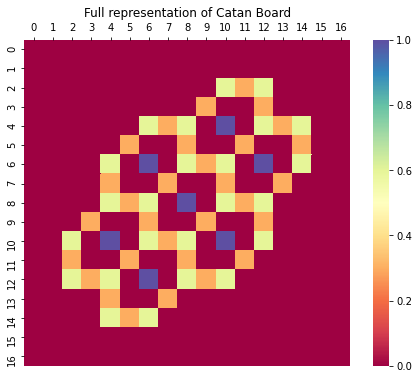

In [3]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(board, square=True, cmap='Spectral')
ax.xaxis.tick_top() # x axis on top
plt.title('Full representation of Catan Board');

In [4]:
edge_cache = np.where(board == 0.3, 1, 0)
vert_cache = np.where(board == 0.6, 1, 0)
face_cache = np.where(board == 1.0, 1, 0)
face_cache_cache = np.transpose(face_cache.nonzero())
edge_cache_cache = np.transpose(edge_cache.nonzero())
vert_cache_cache = np.transpose(vert_cache.nonzero())

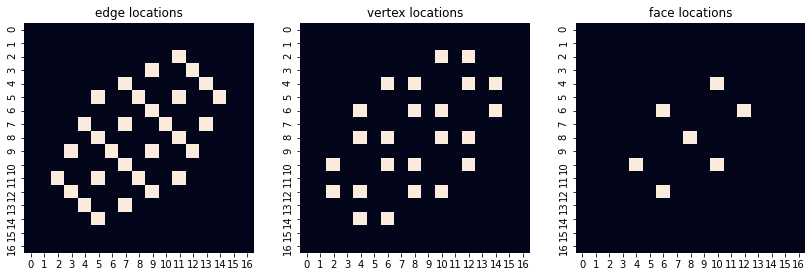

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(14,6))
axs[0].set_title('edge locations')
axs[1].set_title('vertex locations')
axs[2].set_title('face locations')

sns.heatmap(edge_cache, square=True, cbar=False, ax=axs[0])
sns.heatmap(vert_cache, square=True, cbar=False, ax=axs[1])
sns.heatmap(face_cache, square=True, cbar=False, ax=axs[2])

plt.show()

### What are your theoretical chances of getting $n$ resources in the first round?

These are predefined matrices used between both Justin Yang and I, we were both responsible for creating them and they are being reused between our code because their is no funcitonal way to make them different other than to implement this as a double dictionary or something but its still the same code. The transform method is a utilities method designed to make the code faster - it is largely implemented by Justin, my initial approach is provided at the bottom of the document which we used in the prototype, it isn't performant so it was replaced with this.

In [6]:
#what roads are connected to a given house, and what roads connect to those roads?
vertex_to_edge_down = np.array([(1,0),(0,-1),(-1,1)])
vertex_to_edge_up = np.array([(0,1),(-1,0),(1,-1)])

#what are the neighboring vertices?
vertex_to_vertex_down = np.array([(-2,2),(2,0),(0,-2)])
vertex_to_vertex_up = np.array([(-2,0),(0,2),(2,-2)])

#what faces are connected to a given house? 
vertex_to_face_down = np.array([(-2,0), (0,2), (2,-2)])
vertex_to_face_up = np.array([(2,0), (0,-2), (-2,2)])

#what roads are connected to a given road?
edge_to_edge_horizontal = np.array([(-2,1),(-1,-1),(1,1),(2,-1)])
edge_to_edge_vertical = np.array([(-1,-1),(-1,2),(1,-2),(1,1)])
edge_to_edge_diagonal = np.array([(-2,1),(-1,2),(1,-2),(2,-1)])

#what houses are connected to a given road?
edge_to_vertex_horizontal = np.array([(-1,0),(1,0)])
edge_to_vertex_vertical = np.array([(0,-1),(0,1)])
edge_to_vertex_diagonal = np.array([(-1,1),(1,-1)])

#what houses are connected to a given face?
face_to_vertex = np.array([(0,-2),(2,-2),(2,0),(0,2),(-2,2),(-2,0)])

In [7]:
def transform(loc, dest_type):
    if node_board[loc].type == 'R': 
        if node_board[loc[0]+1, loc[1]-1] != None:  
            if dest_type == 'B': 
                return (edge_to_vertex_diagonal + loc).tolist()
            elif dest_type == 'R':
                return (edge_to_edge_diagonal + loc).tolist()
            else: 
                raise ValueError('Location and Transform Mismatch - Cannot convert Road to Building or Road Loc with 1,-1')
        elif node_board[loc[0]+1, loc[1]] == None:
            if dest_type == 'B': 
                return (edge_to_vertex_vertical + loc).tolist()
            elif dest_type == 'R':
                return (edge_to_edge_vertical + loc).tolist()
            else: 
                raise ValueError('Location and Transform Mismatch - Cannot convert Road to Building or Road Loc with 1,0')
        else:   
            if dest_type == 'B': 
                return (edge_to_vertex_horizontal + loc).tolist()
            elif dest_type == 'R':
                return (edge_to_edge_horizontal + loc).tolist()
            else:
                raise ValueError('Location and Transform Mismatch - Cannot convert Road to Building or Road Loc with 0,0') 
            
    elif node_board[loc].type[0] == 'B': # if building
        if node_board[loc[0]-1,loc[1]+1] != None or [loc[0],loc[1]] in [[2,12], [4,14]]:
            if dest_type == 'B': 
                return (vertex_to_vertex_down + loc).tolist()
            elif dest_type == 'R':
                return (vertex_to_edge_down + loc).tolist()
            elif dest_type == 'T':
                return (vertex_to_face_down + loc).tolist()
            else: 
                raise ValueError('Location and Transform Mismatch')
        else:
            if dest_type == 'B': 
                return (vertex_to_vertex_up + loc).tolist()
            elif dest_type == 'R':
                return (vertex_to_edge_up + loc).tolist()
            elif dest_type == 'T':
                return (vertex_to_face_up + loc).tolist()
            else:
                raise ValueError('Location and Transform Mismatch')
    elif node_board[loc].type[0] == 'T': # if face
        if dest_type == 'B':
            return (face_to_vertex + loc).tolist()

In [8]:
def generate_terrain():
    '''
    H: hill
    P: pasture
    M: mountain
    Fi: field
    Fo: forest
    '''
    
    terrain = ['H', 'Fo', 'M', 'Fi', 'P', 'H', 'Fo'] #only one because tabular didn't like it
    
    return terrain


def roll_die():
    return 2+int(6*random.random())+int(6*random.random()) #np.random.random() is really slow

### Populate hex board with meaningful variables
Keep the minimal information needed in the nodes

In [9]:
#Transform Caches
vert_transform_cache = np.transpose(vert_cache.nonzero())
edge_transform_cache = np.transpose(edge_cache.nonzero())
face_transform_cache = np.transpose(face_cache.nonzero())

class Node:
    '''
    loc: the coordinate position of the hex board 
    membership: the player ownership. 0 denotes no ownership
    type: 
        - B  - building
        - BH - house
        - BC - city
        - R  - road
        - TH, TFo, TM, TFi, TP - terrain with a resource
    data: 
        - dice roll associated with terrain type structures; -1 else
    '''
    
    def __init__(self, loc, node_type, data = -1): #set default to -1 because it is only for face nodes
        self.loc = loc
        self.membership = 0
        self.type = node_type
        self.data = data

    def __str__(self):
        return f'{self.loc}, {self.membership}, {self.type}, {self.data}'
    

def initialize_board():
    board = np.empty((17,17), dtype=np.object)
    
    for x, y in vert_cache_cache:
        board[x,y] = Node((x,y), 'B') #building
    for x, y in edge_cache_cache: 
        board[x,y] = Node((x,y), 'R') #road
    for (x,y), t in zip(face_cache_cache, generate_terrain()):
        board[x,y] = Node((x,y), 'T' + t, data = roll_die()) #terrain, only place the data variable gets used

    face_access = {(x,y): board[x,y].type[1:] for x,y in face_cache_cache}
    access_roll = {(x,y): board[x,y].data for x,y in face_cache_cache}
    roll_access = {}
    for k, v in access_roll.items():
        roll_access[v] = roll_access.get(v, []) + [k]
    access_face = {}
    for k, v in face_access.items():
        access_face[v] = access_face.get(v, []) + [k]
    
    return board, face_access, roll_access, access_face

### Create players
Actions should go through the players

In [10]:
class Player:
    def __init__(self, player_num):
        self.num = player_num
        self.hand = {'H': 2, 'Fo': 2, 'M': 0, 'Fi': 3, 'P': 3} #they are able to build 1 road and two builds at start
        
        #locations
        self.houses = []
        self.roads = []
        
        #amount of settlement associated with each resource
        self.farms = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 0, 'P': 0}
        
        #victory points
        self.points = 0
    
    def __str__(self): #used for debugging
        return f'Player number {self.num}: \n{sum(self.hand.values())} cards:{self.hand} \n'+\
               f'{len(self.houses)} houses:{self.houses} \n' +\
               f'{len(self.roads)} roads: {self.roads} \n' +\
               f'{sum(self.farms.values())} farms: {self.farms} \n' +\
               f'{self.points} victory points'
        
    def add_house(self, loc, city=False): 
        if not city:
            self.houses.append(loc)
            self.hand['H']  -= 1 #subtract the required resources
            self.hand['Fo'] -= 1
            self.hand['Fi'] -= 1
            self.hand['P'] -= 1
            
            node_board[loc].membership = self.num
            node_board[loc].type = 'BH'
        else:
            self.hand['Fi'] -= 2 #subtract the required resources for a city
            self.hand['M'] -= 3
            node_board[loc].type = 'BC'
                            
        for x,y in transform(loc, 'T'):
            if node_board[x,y] != None:
                self.farms[face_access[x,y]] += 1 #increment farm score by 1, works because need house to make city
        
        self.points += 1 #always add point if house is added

    def add_road(self, loc):
        self.roads.append(loc)
        self.hand['H']  -= 1 #subtract resources for road
        self.hand['Fo'] -= 1
        node_board[loc].membership = self.num
        
    

def initialize_game(agent_count = 2):
    
    players = [Player(player_num) for player_num in range(1, agent_count+1)]
    predef_starts = [(4,8), (12,8)]
    predef_roads =  [(5,8), (11,8)] #need to start players somewhere specific to avoid having no resource generation, needs road
    
    for player, house, road in zip(players, predef_starts, predef_roads):
        player.add_house(house)
        player.add_road(road)
        
    player1, player2, *player_overflow = players #added in case we want more agents, overflow is a precaution
    
    return player1, player2

## Define game logic 

### Find what moves are avaliable to the player

In [11]:
# make sure that this house's location isn't neighboring anyone
def assert_surrounding_verts(x,y):
    for vert in transform((x,y), 'B'): #for all possible transformations
        if node_board[tuple(vert)] != None and node_board[tuple(vert)].membership != 0: #check valid
            return False 
    return True 


def check_avaliable_vert(player):
    branches = list(set([tuple(branch) for road in player.roads for branch in transform(road, 'R') \
                                       if tuple(branch) in player.roads])) #ignore branches that aren't ours, too costly
    
    #from the eligible roads, get the eligible houses 
    houses = [tuple(a) for branch in branches for a in transform(tuple(branch), 'B') \
                                  if assert_surrounding_verts(a[0],a[1]) and node_board[a[0],a[1]].membership == 0]

    return list(set(houses)) #remove duplicates using set
    
    
def check_avaliable_edge(player):
    nodes = list(set([tuple(branch) for road in player.roads for branch in transform(road, 'R')])) #for all edges
    
    # check all potential edges for elegibility
    nodes = [node for node in nodes if node_board[node] != None and node_board[node].membership == 0]
    return nodes


# later on: the state-action loop that the agent can take is a while loop
def generate_possible_actions(player, state):
    '''
    Look at player's resources to see what high-level actions can be done
    Helper function for environment_to_state()
    
    If the player has enough resource, call check_avaliable_vert() and/or check_avaliable_edge() to generate 
    location options. 
    Return possible actions to the player in the form: (first two actually will go into the state)
        - can a road be built
        - can a building be built
        - of the buildings that can be built, what resource do they provide (?)
        - of the roads that can be built, (possibly) what resource do they build towards
        - etc? maybe not all of these either
    
    actions: of the form (bool, bool, ...)
        
    '''
    #check resources
    build_road = all([i > 0 for i in map(player.hand.get, ['H', 'Fo'])]) #road, requires 1 brick 1 wood
    build_house = all([i > 0 for i in map(player.hand.get, ['H', 'Fo', 'Fi', 'P'])]) #house, requires everything but rock
    build_city = player.hand['P'] > 1 and player.hand['M'] > 2 #can build city, requires 2 wheat 3 rocks
    
    #get building best on avaliable resources
    if build_house:
        nodes_house = check_avaliable_vert(player)
        build_house = len(nodes) != 0 
        for node in nodes_house:
            pass #currently unimplemented, gets handled elsewhere don't have time to fix

    if build_road:
        nodes_road = check_avaliable_edge(player)
    if build_city:
        pass #Currently unimplemented, gets handled elsewhere don't have time to fix
        
    
    return actions

### Encode the state and action space for the RL agent

In [12]:
action_resource = {0: 'H', 1: 'Fo', 2: 'M', 3: 'Fi', 4: 'P'} #val --> type
action_resource_inv = {v: k for k, v in action_resource.items()} #type --> val

def environment_to_state(player):
    
    '''
    State space: (12,12) x (2,2,2,2,2) x (4,4) x (2,2,2)
    (12,12):
    Index 0: # of player roads (1 to 12)
    Index 1: # of opponent roads (1 to 12)
    
    (2,2,2,2,2)
    Index 2: # player farm > opponent farm (Hill)
    Index 3: # player farm > opponent farm (Forest)
    Index 4: # player farm > opponent farm (Mountain)
    Index 5: # player farm > opponent farm (Field)
    Index 6: # player farm > opponent farm (Pasture)
    
    (6,6)
    Index 7: # of player victory points (1-6)
    Index 8: # of opponent victory points (1-6)
    
    (2,2,2)
    Index 9: can build road?
    Index 10: can build house?
    Index 11: can build city? 
    
    '''
    state = [] 
    state.append(len(player1.roads)) 
    state.append(len(player2.roads))
    
    state += [int(x > y) for x,y in zip(player1.farms.values(), player2.farms.values())]
    
    state.append(player1.points)
    state.append(player2.points)
    
    state.append(int(all([i > 0 for i in map(player.hand.get, ['H', 'Fo'])]) and len(player.roads) < 11)) #sanity check for road
    state.append(int(all([i > 0 for i in map(player.hand.get, ['H', 'Fo', 'Fi', 'P'])])) \
                                 and int(bool(check_avaliable_vert(player))))
    state.append(int(player.hand['Fi'] > 1 and player.hand['M'] > 2)) #boolean for it we can have city or not, works same 
        
    return state


def optimize_selection(choices, goals):
    min_dist = np.inf #make sure it isn't possible to have worse min distance
    best_loc = None
    for choice in choices:
            for goal in goals:
                dist = np.linalg.norm(np.array(goal) - np.array(choice)) #calc euclidean distance
                if dist < min_dist:
                    best_loc = choice
                    min_dist = dist
    return best_loc

    
    
def roll_for_turn():
    roll = roll_die()
    if roll in roll_access.keys():
        for loc in roll_access[roll]: 
            for vert in transform(loc, 'B'):
                if node_board[tuple(vert)].membership == player1.num:
                    if node_board[tuple(vert)].type[1] == 'H':
                        player1.hand[face_access[loc]] += 1 
                    else:                                  
                        player1.hand[face_access[loc]] += 2

                elif node_board[tuple(vert)].membership == player2.num: 
                    if node_board[tuple(vert)].type[1] == 'H':
                        player2.hand[face_access[loc]] += 1 
                    else:                                   
                        player2.hand[face_access[loc]] += 2 
                        
    
def step(state, action, player):
    '''
    action: 
    (0,0): do nothing
    (1,:): build a road
    (2,:): build a house
    (3,:): build a city
    (:,0): Target hill  
    (:,1): Target forest
    (:,2): Target mountain
    (:,3): Target field
    (:,4): Target pasture
    '''
        
    if action != (0,0):
        targets = access_face[action_resource[action[1]]]

        #none checks are because random action can return something that isn't possible, just checking to make sure it is
        if action[0] == 1:
            candidates = check_avaliable_edge(player)
            best_loc = optimize_selection(candidates, targets)
            if best_loc != None: #make sure that action isn't invalid
                player.add_road(best_loc)
            else:
                action = (0,0) #if it is, do nothing
            
        elif action[0] == 2:
            candidates = check_avaliable_vert(player)
            best_loc = optimize_selection(candidates, targets)
            if best_loc != None: #make sure that action isn't invalid
                player.add_house(best_loc)
            else: #if it is, do nothing
                action = (0,0)
            
        elif action[0] == 3: #errors with this get handled elsewhere
            candidates = list(set([house for house in player.houses for target in targets \
                                                    if list(target) in transform(house, 'T')]))
            best_loc = random.choice(candidates)
            player.add_house(best_loc, city=True)

    
    if player.points == 6: #check if win condition is met
        reward = 1 
        new_state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        action = (0,0) #set reward to 1, state to terminal and action to nothing
    else:
        reward = 0
        new_state = environment_to_state(player) #else convert action to new state
    
    return new_state, reward, action

In [13]:
#helper method to show what the agent is doing in any given board state
def plot_board():
    board2 = board.copy()
    for x in range(17):
        for y in range(17):
            if node_board[x,y] != None:
                if node_board[x,y].type == 'BH':
                    board2[y,x] = node_board[x,y].membership + 5
                elif node_board[x,y].type[0] == 'T':
                    board2[y,x] = 0
                elif node_board[x,y].type == 'R' and node_board[x,y].membership != 0:
                    board2[y,x] = node_board[x,y].membership + 3.5
                else: 
                    board2[y,x] = node_board[x,y].membership 
            else:
                board2[y,x] = 0
    sns.heatmap(board2, square=True,cmap='viridis')

### Agent implementation: Sarsa(0)

In [14]:
def take(arr):
    return arr[arr!=0]

#written by Joshua Duquette exclusively, used between both sets of code because its really not possible to do any other way
def encode_possible_actions(player, state):
    
    actions = [(0,0)] #always able to take no action
    if state[-3] == 1 and len(player.roads) < 11:  #check if able to build road
        candidates = check_avaliable_edge(player) #is there avaliable edge
        if candidates:
            actions = actions + [(1, i) for i in np.arange(5)] 
    if state[-2] == 1 and len(player.houses) < 6: #check house
        if check_avaliable_vert(player):
            actions = actions + [(2, i) for i in np.arange(5)]
    if state[-1] == 1: #check city
        city_actions = list(set([(3,action_resource_inv[face_access[tuple(targets)]]) \
                                 for house in player.houses \
                                 for targets in transform(house, 'T') \
                                 if node_board[house].type == 'BH' and node_board[tuple(targets)] != None]))

        actions += city_actions
    
    return actions

def epsilon(state, ret_counts): #never used because it causes issues with tabular method and wtf does it even mean in approx.
    return 10/(10 + np.min(ret_counts[tuple(state)]))

def epsilon_greedy(state, ret_counts, qvalue, player):
    possible_actions = encode_possible_actions(player, state)
    if random.random() < epsilon(state, ret_counts) * 0.1: #basically 1 * 0.1 = 0.1, but it looks cool so hey
        random_act = random.choice(possible_actions) #get random action from possible actions
        return random_act
    else:
        argmax = np.column_stack(np.unravel_index(np.argsort(qvalue[tuple(state)], axis=None), (4,5))).tolist()
        action = [tuple(i) for i in reversed(argmax) if tuple(i) in possible_actions] #get best action that is possible
        return action[0]

#code runs forever sometimes, turns out you need to check if the agents didn't mess up so much they can't play
def check_stalemate(player, state):
    #hand doesn't have stuff to make house anymore
    if ((player. hand['Fi'] == 0 or player. hand['P'] == 0) and \
       (player.farms['Fi'] == 0 or player.farms['P'] == 0)) or \
       (len(player.roads) >= 11 and encode_possible_actions(player, state) == [(0,0)]): #they boxed each other in
        return True
    return False

def indexer(state, action):
    return tuple(reduce(operator.concat, (state,list(action)))) #stuffs state and action --> state-action

In [15]:
def step_move_update(state, action, player, qvals, ret_counts): #sort of depreciated for the time being for debugging purposes
    index = indexer(state, action) #get current index
    ret_counts[index] += 1 #update returns
    #step through SARSA(0) algorithm
    S_p, R, A_p = step(state, action, player)
    A_p = epsilon_greedy(S_p, ret_counts, qvals, player)
        
    qvals[index] += (R + qvals[indexer(S_p, A_p)] - qvals[index]) / (ret_counts[index] \
                                                if ret_counts[index] != 0. else 10.)
    return S_p, A_p, qvals, ret_counts

100%|█████████▉| 999991/1000001 [3:20:12<00:00, 96.09it/s]   

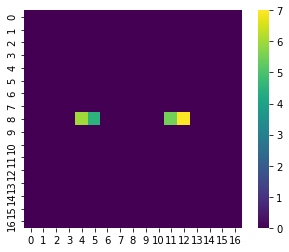

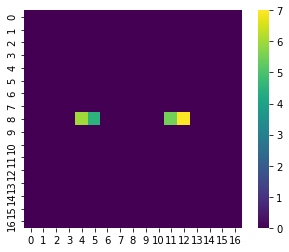

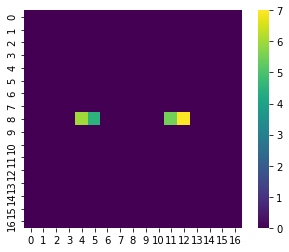

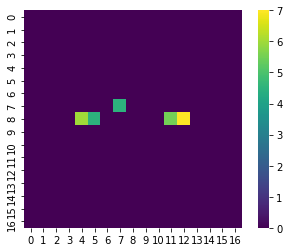

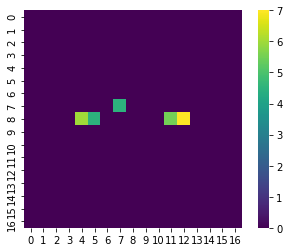

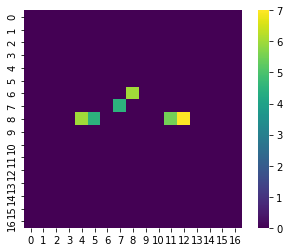

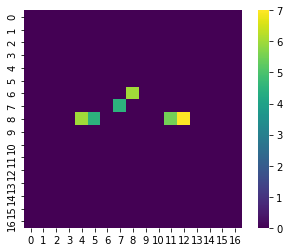

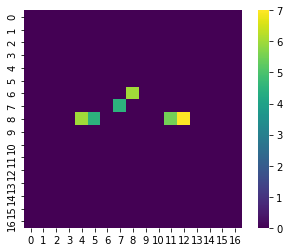

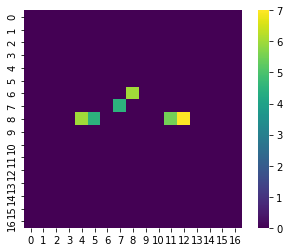

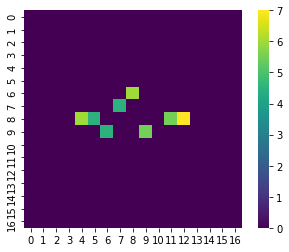

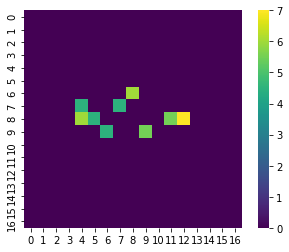

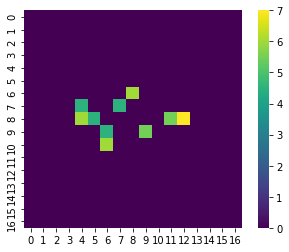

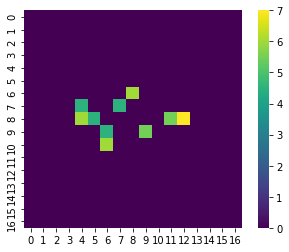

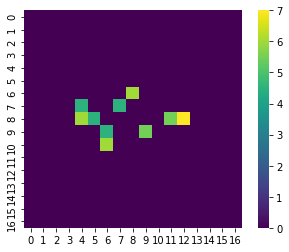

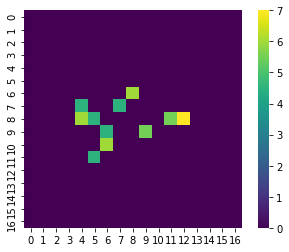

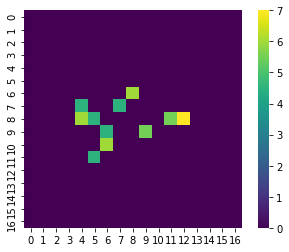

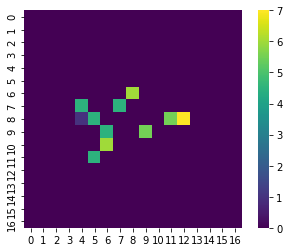

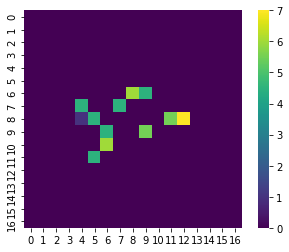

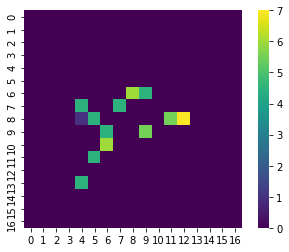

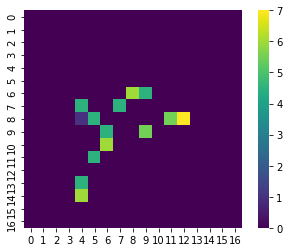

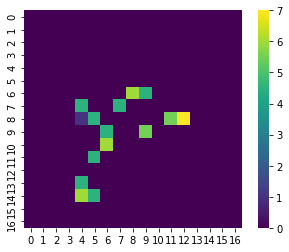

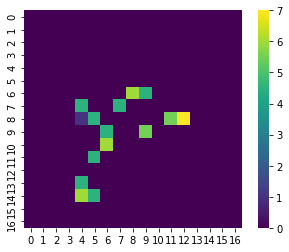

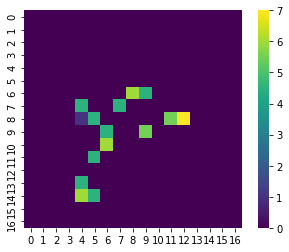

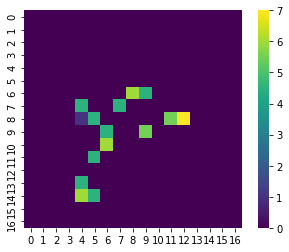

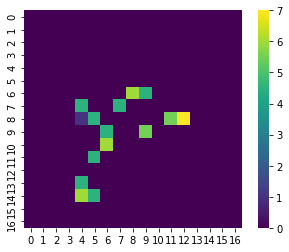

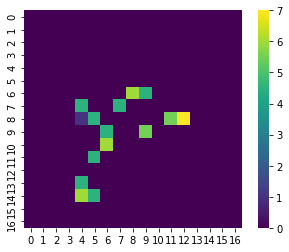

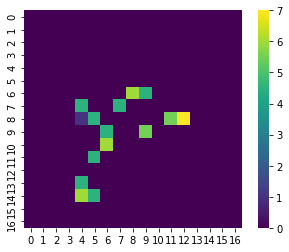

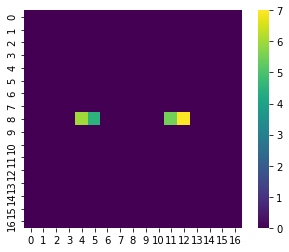

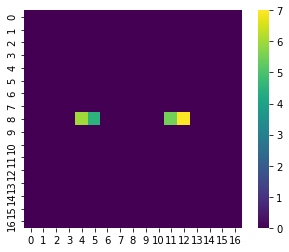

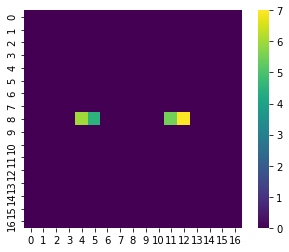

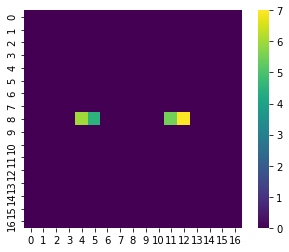

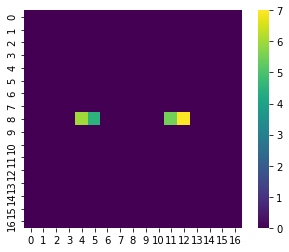

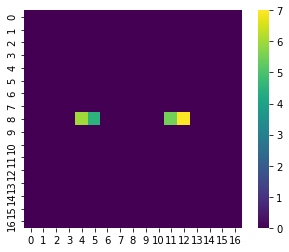

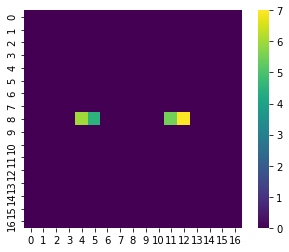

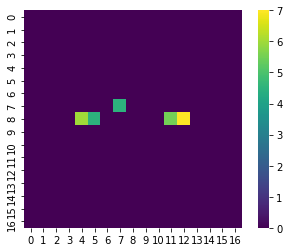

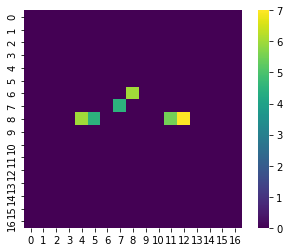

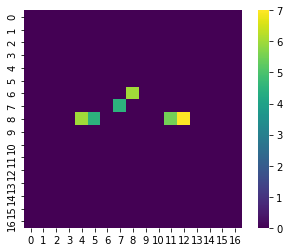

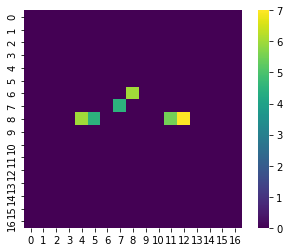

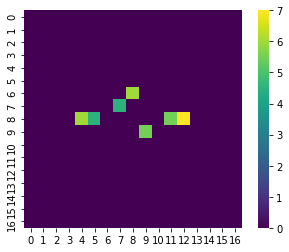

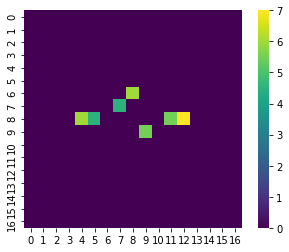

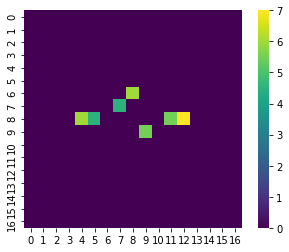

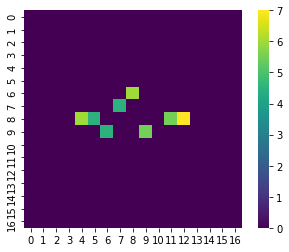

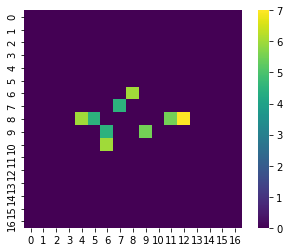

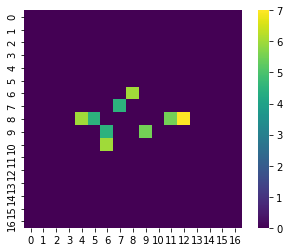

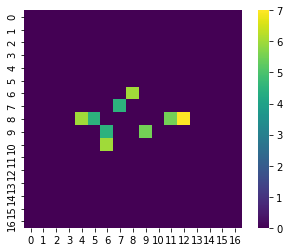

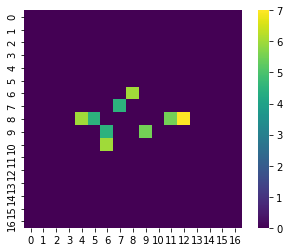

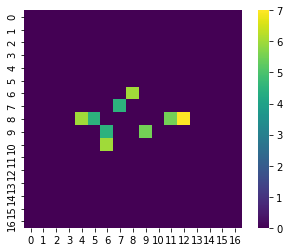

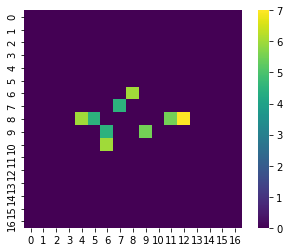

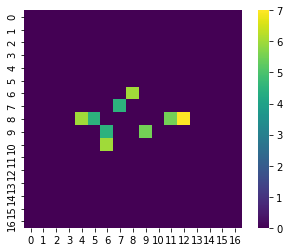

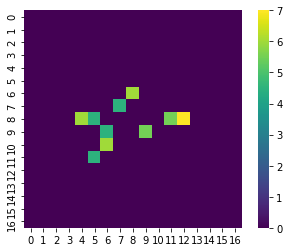

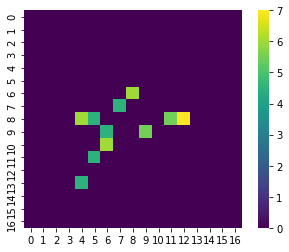

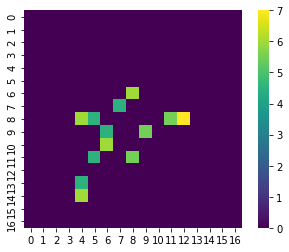

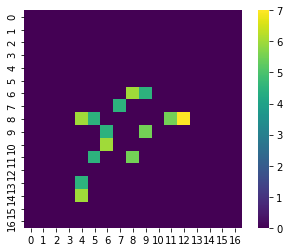

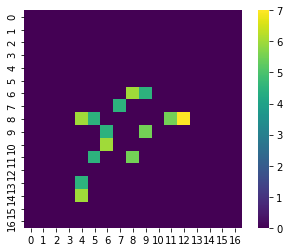

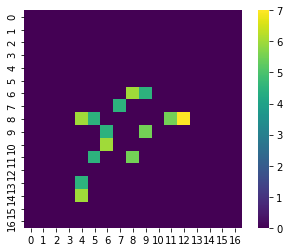

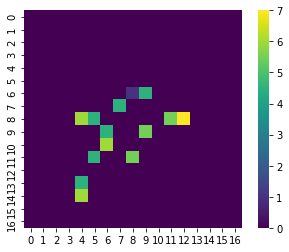

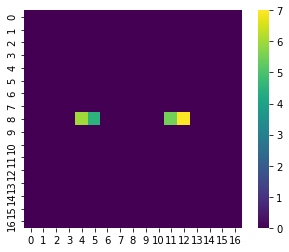

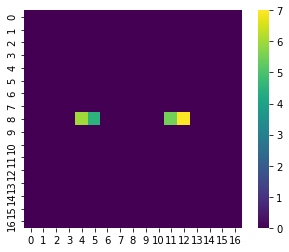

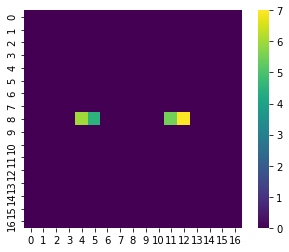

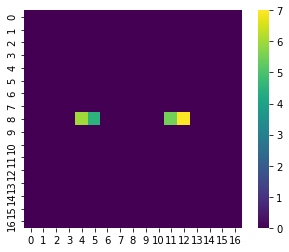

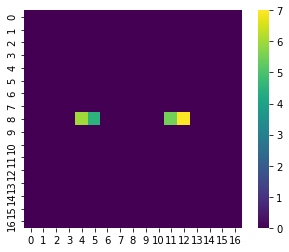

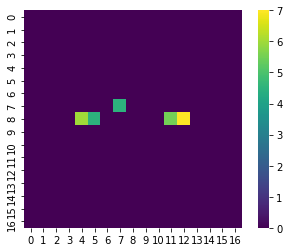

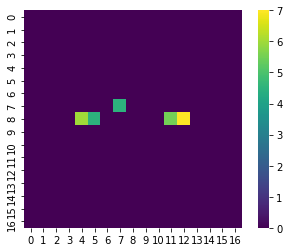

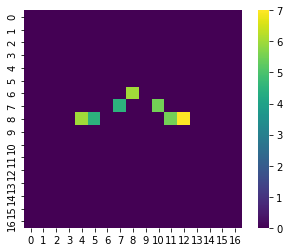

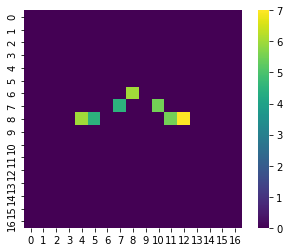

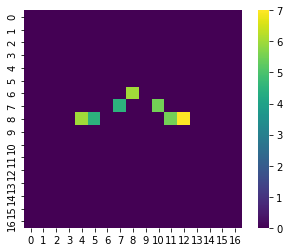

100%|█████████▉| 999991/1000001 [3:20:30<00:00, 96.09it/s]

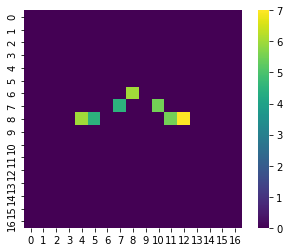

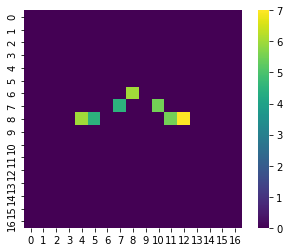

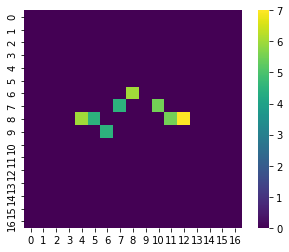

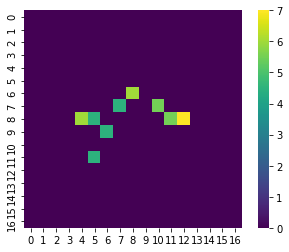

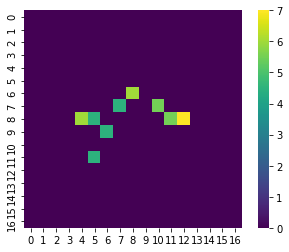

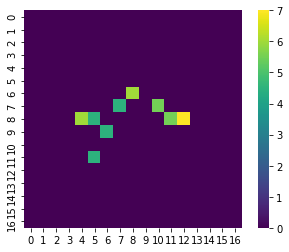

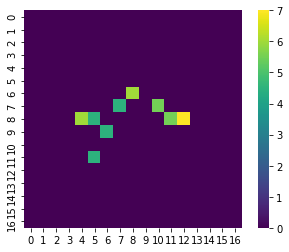

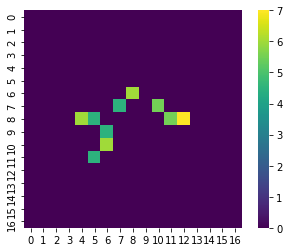

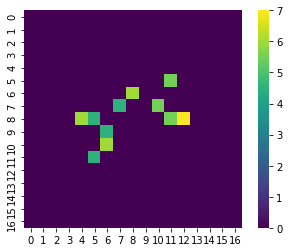

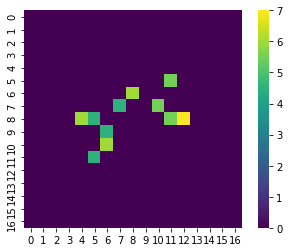

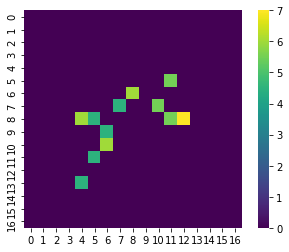

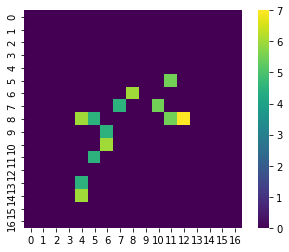

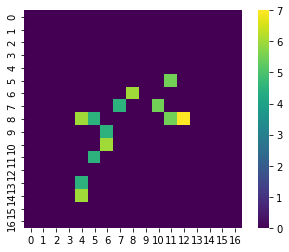

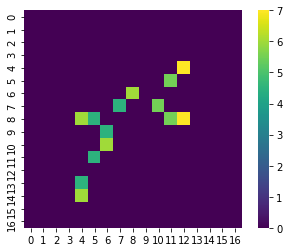

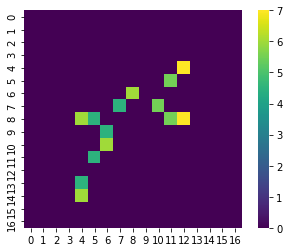

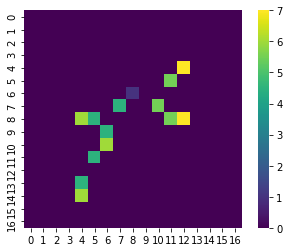

100%|█████████▉| 999999/1000001 [3:20:34<00:01,  1.21it/s]

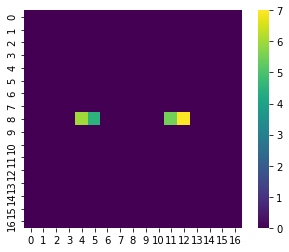

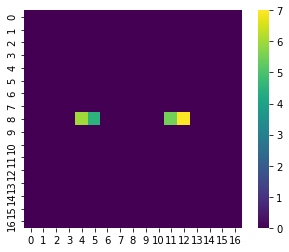

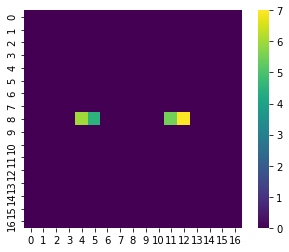

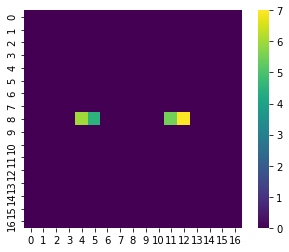

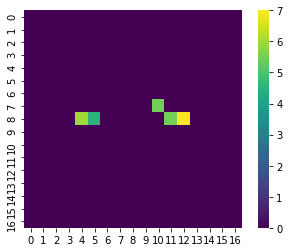

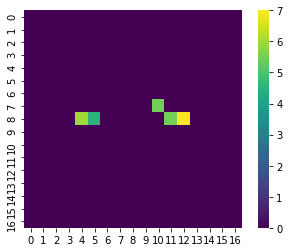

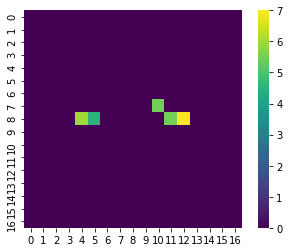

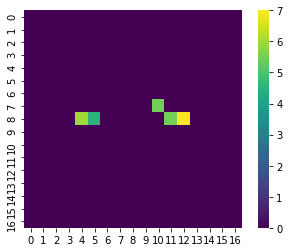

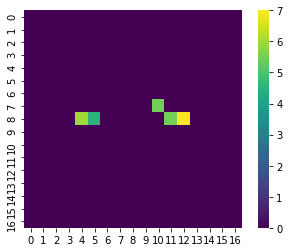

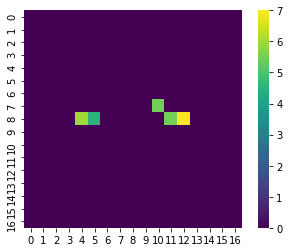

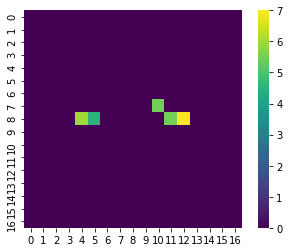

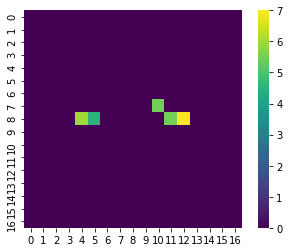

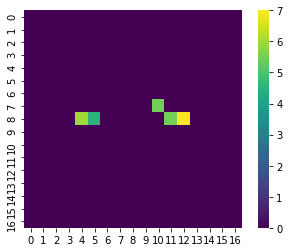

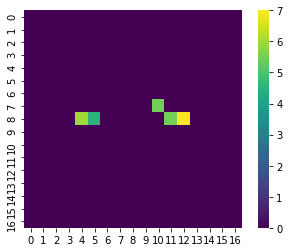

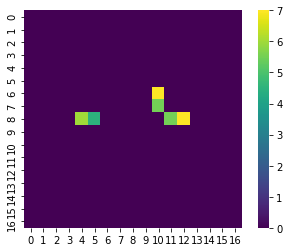

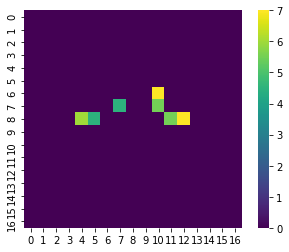

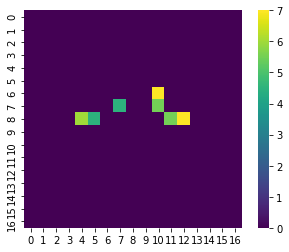

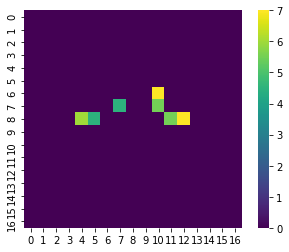

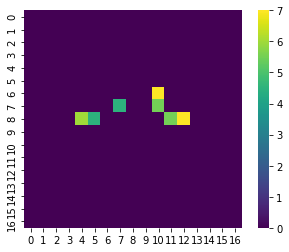

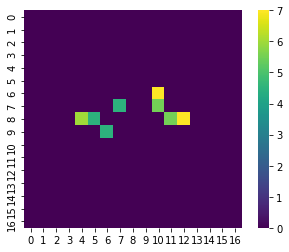

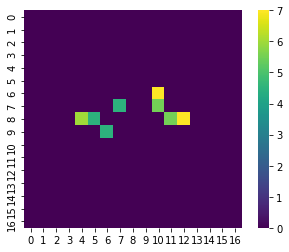

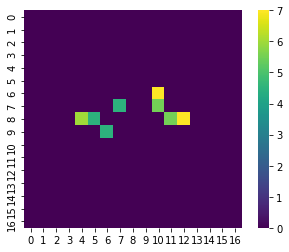

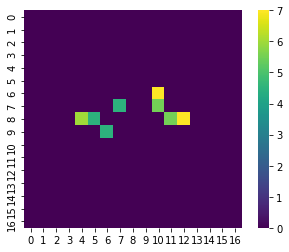

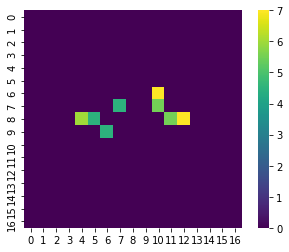

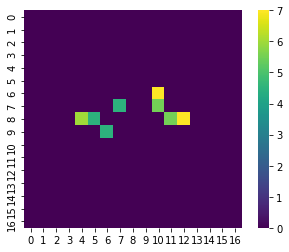

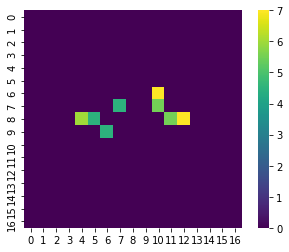

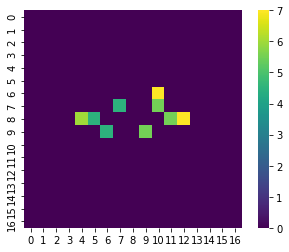

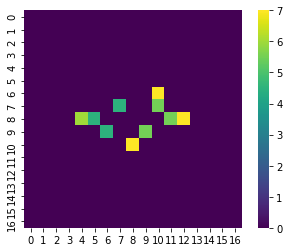

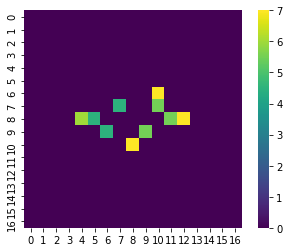

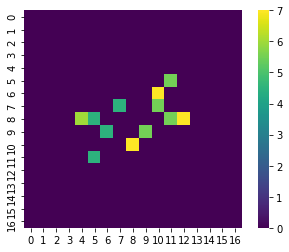

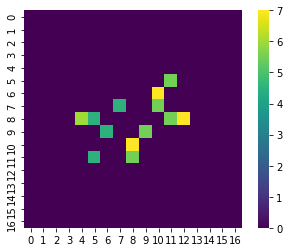

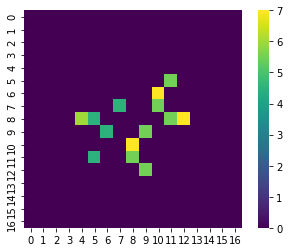

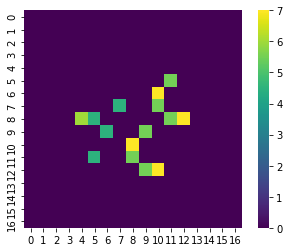

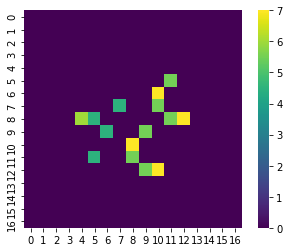

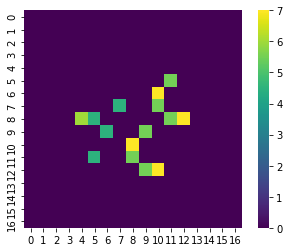

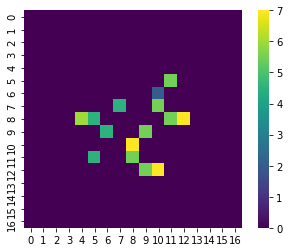

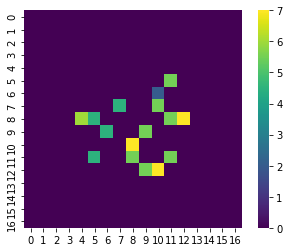

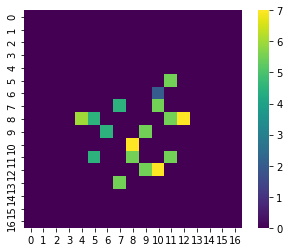

100%|█████████▉| 1000000/1000001 [3:20:44<00:03,  3.62s/it]

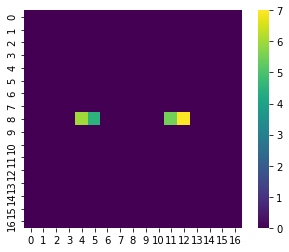

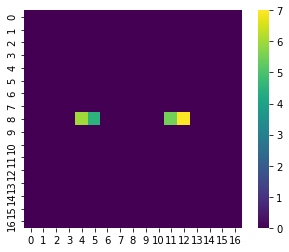

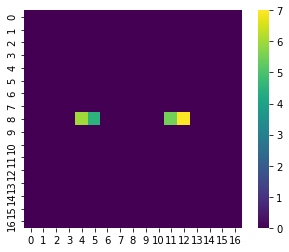

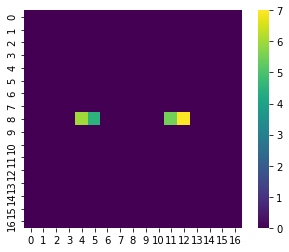

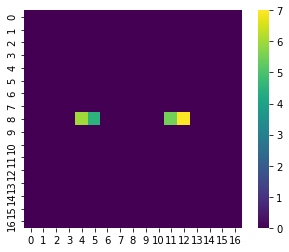

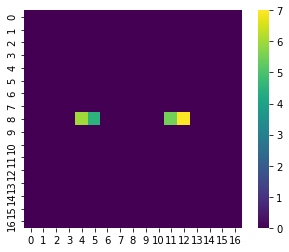

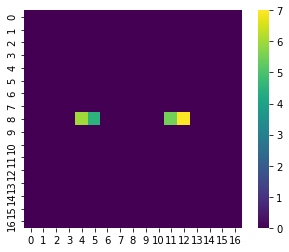

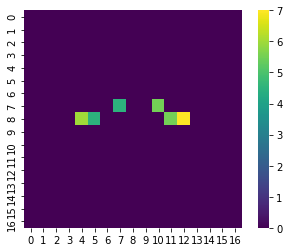

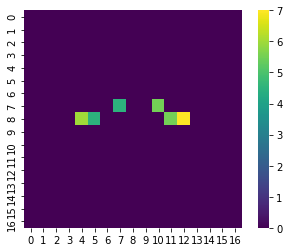

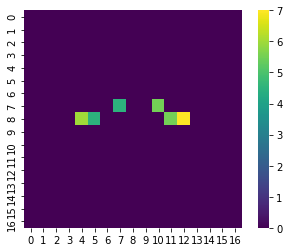

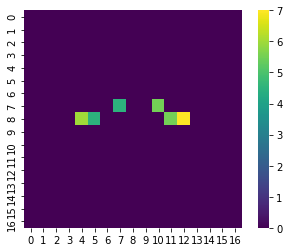

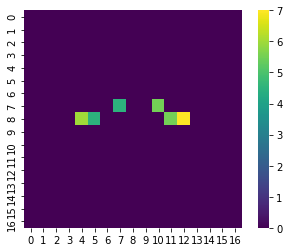

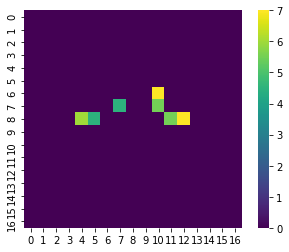

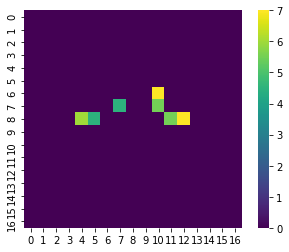

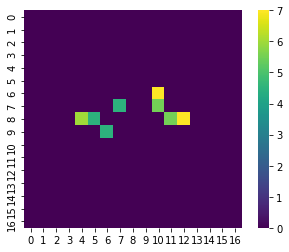

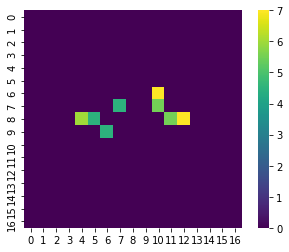

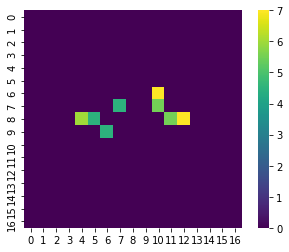

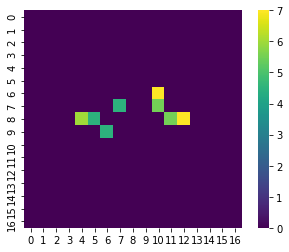

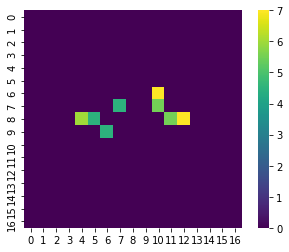

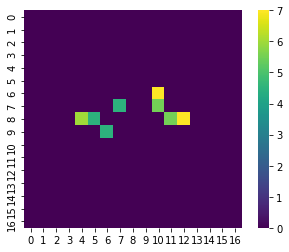

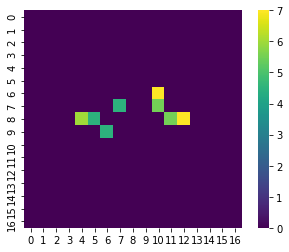

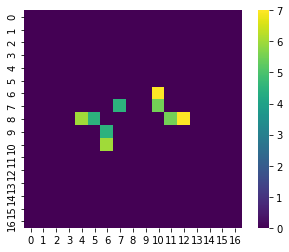

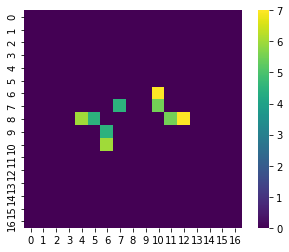

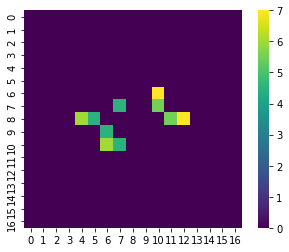

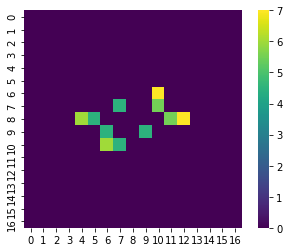

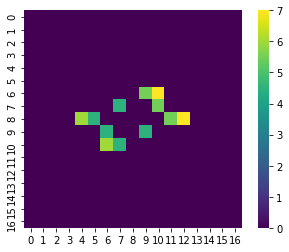

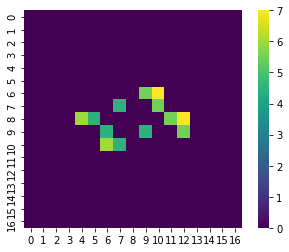

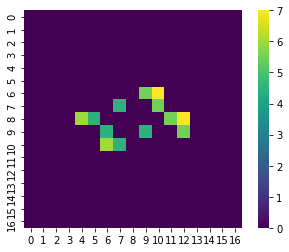

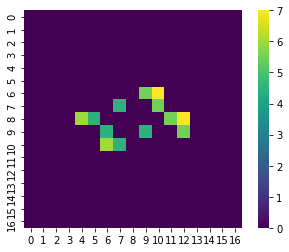

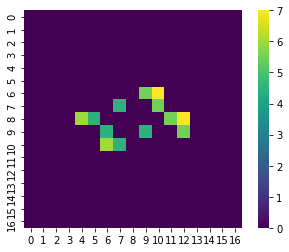

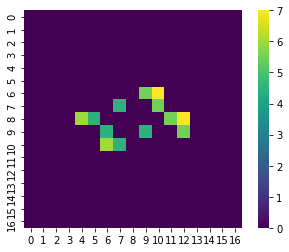

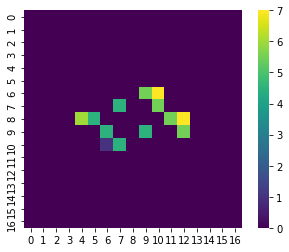

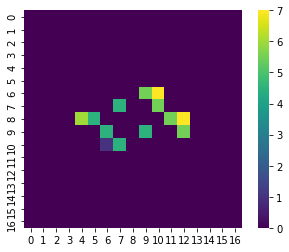

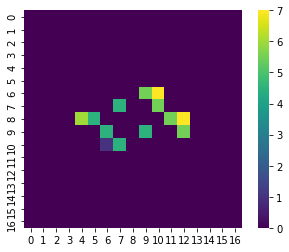

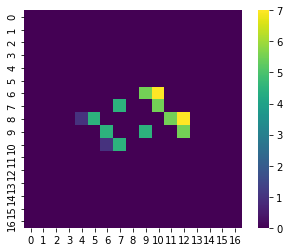

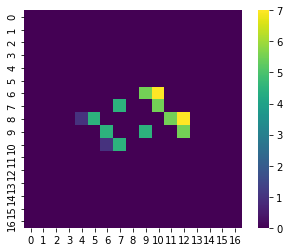

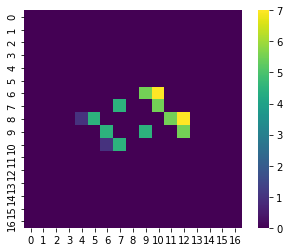

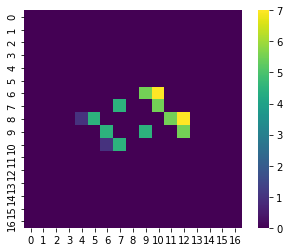

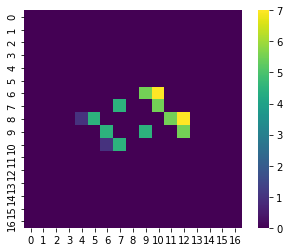

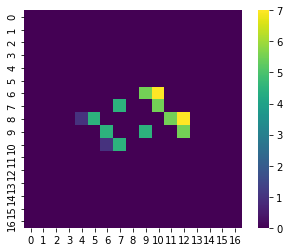

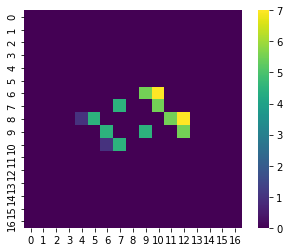

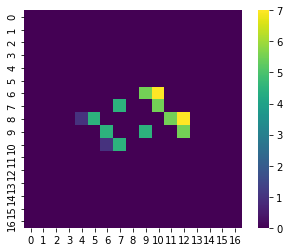

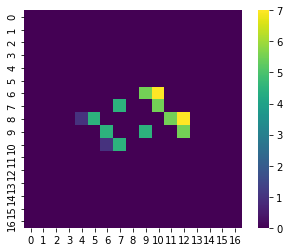

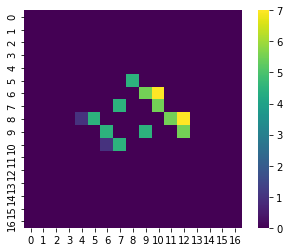

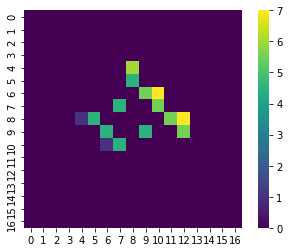

100%|██████████| 1000001/1000001 [3:20:56<00:00, 82.94it/s]


In [16]:
Q_1 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))
Q_2 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))
returns_counts_1 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))
returns_counts_2 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))
win1, win2 = 0, 0
stales1, stales2 = 0, 0
counts=1

for ep in tqdm(range(1000001), position=0, leave=True): #some god-forsaken error where tqdm created newlines, fixed with this

    counts+=1e-4
    node_board, face_access, roll_access, access_face = initialize_board() #set up everything
    player1, player2 = initialize_game() #set up players

    
    #get initial states and actions for players
    S_1 = environment_to_state(player1)
    A_1 = epsilon_greedy(S_1, returns_counts_1, Q_1, player1)
    S_2 = environment_to_state(player2)
    A_2 = epsilon_greedy(S_2, returns_counts_2, Q_2, player2)
    while S_1 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or S_2 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]: #if not terminal
         
        # player 1 turn
        roll_for_turn()
        
        S_p1, A_p1, Q_1, returns_counts_1 = step_move_update(S_1, A_1, player1, Q_1, returns_counts_1)
        S_1, A_1 = S_p1, A_p1
        
        #check win and stalemate conditions for player1
        stalemate1 = check_stalemate(player1, S_1)
        if S_1 == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or stalemate1:
            if stalemate1: 
                stales1 += 1
            else:
                Q_2[indexer(S_2, A_2)] += 0 / (returns_counts_2[indexer(S_2, A_2)]\
                                    if returns_counts_2[indexer(S_2, A_2)] != 0. else 10.)
                win1 += 1
            break #treat stalemate like terminal episode

            
        #player 2 turn
        roll_for_turn()
        
        S_p2, A_p2, Q_2, returns_counts_2 = step_move_update(S_2, A_2, player2, Q_2, returns_counts_2)
        S_2, A_2 = S_p2, A_p2
        
        #check win and stalemate conditions for player2
        stalemate2 = check_stalemate(player2, S_2)
        if S_2 == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or stalemate2:
            if stalemate2:
                stales2 += 1
            else: 
                Q_1[indexer(S_1, A_1)] += 0 / (returns_counts_1[indexer(S_1, A_1)]\
                                    if returns_counts_1[indexer(S_1, A_1)] != 0. else 10.)

                win2 += 1
            break
            
        #plot the last episodes to spot-check performance
        if ep > 999995:
            plot_board()
            plt.show()

In [17]:
win1, win2, stales1, stales2 #quick sanity check to see if they are playing the game

(254154, 295630, 230778, 219439)

In [18]:
def argmax_vectorized(state, weights, possible_actions):
    #for all state-action pairs, matmul weights and argmax the best one, then do lookup in possible_actions
    best_act = possible_actions[np.argmax(np.matmul(weights, np.array([state + list(A) \
                                                               for A in possible_actions]).T))] 
    return best_act

def epsilon_greedy(state, weights, player):
    possible_actions = encode_possible_actions(player, state)
    if random.random() < 0.1: #chance of 0.1 to explore
        random_act = random.choice(possible_actions)
        return random_act
    else:
        return argmax_vectorized(state, weights, possible_actions) #get best move given state, weights and possible actions
    
def q_hat(weights, state, action):
    return np.matmul(weights.T, state + list(action))

In [20]:
w_1 = np.random.random(14) #feature vector is just state-action pair, 12 (states) + 2 (actions) so weights are the same
w_2 = np.random.random(14)
returns_counts_1 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))
returns_counts_2 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))

alpha = 0.95 #high learning rate because we don't want stalemates as soon as possible
gamma = 1 #no discounted future rewards
win1, win2 = 0,0
wins1, wins2 = [], []
stale1, stale2 = 0,0
stales1, stales2 = [], [] 
j = 0
for ep in tqdm(range(10001)):
    j += 1
    #initialize new episode
    node_board, face_access, roll_access, access_face = initialize_board()
    player1, player2 = initialize_game()
    
    #get initial state and action for each player
    S_1 = environment_to_state(player1)
    A_1 = epsilon_greedy(S_1, w_1, player1)
    S_2 = environment_to_state(player2)
    A_2 = epsilon_greedy(S_2, w_2, player2)
    
    while S_1 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or S_2 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]: #while non-terminal
        
        #player 1 move
        roll_for_turn()
        S_p, R, A_p = step(S_1, A_1, player1)
                 
        stalemate1 = check_stalemate(player1, S_1) #this took us ages to figure out
        if S_p == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or stalemate1: #won or stalemated
            if stalemate1: 
                stale1 += 1
                stales1.append(j) #keeping track of wins and stales along with iter they occured at
            else:
                win1 += 1
                wins1.append(j)
                w_2 = (w_2 + alpha * w_2 * (-1 - q_hat(w_2, S_2, A_2))) / np.max(w_2) #needed to scale values
            w_1 = (w_1 + alpha * w_1 * (R - q_hat(w_1, S_1, A_1))) / np.max(w_1) #used max to keep it between -1 and 1
            break
            
        A_p = epsilon_greedy(S_p, w_1, player1)
        w_1 = (w_1 + alpha * w_1 * (R + gamma * q_hat(w_1, S_p, A_p) - q_hat(w_1, S_1, A_1))) / np.max(w_1) #weight update
        S_1, A_1 = S_p, A_p
                    
            
        #player 2 move
        roll_for_turn()
        S_p, R, A_p = step(S_2, A_2, player2)
        
        stalemate2 = check_stalemate(player2, S_2)
        if S_p == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or stalemate2: #won or stalemated
            if stalemate2:
                stale2 += 1
                stales2.append(j)
            else:
                win2 += 1
                wins2.append(j)
                w_1 = (w_1 + alpha * w_1 * (-1 - q_hat(w_1, S_1, A_1))) / np.max(w_1) #punish player 1 for losing
            w_2 = (w_2 + alpha * w_2 * (R - q_hat(w_2, S_2, A_2))) / np.max(w_2) #update player 2
            break
        A_p = epsilon_greedy(S_2, w_2, player2)
        w_2 = (w_2 +  alpha * w_2 * (R + gamma * q_hat(w_2, S_p, A_p) - q_hat(w_2, S_2, A_2))) / np.max(w_2)
        S_2, A_2 = S_p, A_p

100%|██████████| 10001/10001 [02:25<00:00, 68.91it/s]


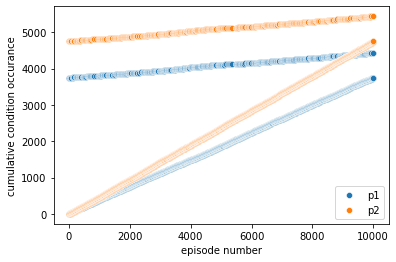

In [21]:
#some code to check if linear func. approx. converged or not - this is not mine this is solely Justin Yang's
match_data = [('p2_stale' ,stales) for stales in  stales2] + \
[('p1_stale' ,stales) for stales in  stales1] + \
[('p2_win' ,wins) for wins in  wins2] + \
[('p1_win' ,wins) for wins in  wins2]
df = pd.DataFrame(match_data, columns = ['player', 'index'])
df[['player', 'condition']] = df['player'].str.split('_', expand = True)
sns.scatterplot(data = df[df.player == 'p1'], y= np.arange(len(df[df.player == 'p1'])), x='index', label='p1')
sns.scatterplot(data = df[df.player == 'p2'], y= np.arange(len(df[df.player == 'p2'])), x= 'index', label='p2')
plt.xlabel('episode number')
plt.ylabel('cumulative condition occurance')
plt.legend(loc='best');

## Code Graveyard as Demonstration of Seperate Work

In [ ]:
# make sure that this house's location isn't neighboring anyone
def assert_surrounding_verts(x,y):   # for a candidate house location
    if node_board[x-1,y+1] != None or [x,y] in [[2,12], [4,14]]: # if it's a "down-diagonal" vertex 
        potential_verts = [[-2,2],[2,0],[0,-2]] # then these are the possible neighbors
        for vert in potential_verts: # for each possible neighbor
            # check that it isn't out of bounds and that it isn't already owned
            if node_board[x+vert[0],y+vert[1]] != None \
            and node_board[x+vert[0],y+vert[1]].membership != 0:
                return False   # otherwise it fails the check
    else:  # otherwise if it's an "up-diagonal" vertex
        potential_verts = [[-2,0],[0,2],[2,-2]] # then these are the possible neighbors
        for vert in potential_verts:   # for each possible neighbor
            # check that it isn't out of bounds and that it isn't already owned
            if node_board[x+vert[0],y+vert[1]] != None and \
               node_board[x+vert[0],y+vert[1]].membership != 0:  
                return False  # otherwise it fails the check
    return True
    
vert_cache_cache = vert_cache_cache
def check_avaliable_vert(player):
    
    nodes = []
    for x,y in vert_cache_cache: # for every possible house location
        if node_board[x,y].membership == 0:      # if it isn't already owned
            if assert_surrounding_verts(x,y):      # and if this location isn't neighboring anyone else
                # check for the roads now:
                if node_board[x-1,y+1] != None or [x,y] in [[2,12], [4,14]]: # if it's "down-diagonal"
                    for key, value in vert2edge_down_diag.items(): # then, checking for each nearby road
                        # if you occupy the road
                        if node_board[x+key[0],y+key[1]] != None and node_board[x+key[0],y+key[1]].membership == player.num:
                            # and you also occupy one of the road's neighbors 
                            check1 = node_board[x+value[0][0],y+value[0][1]]
                            check2 = node_board[x+value[1][0],y+value[1][1]]
                            if check1 != None and check1.membership == player.num or\
                               check2 != None and check2 == player.num:
                                # add the house location to the possible house locations
                                nodes.append(node_board[x,y]) 
                else: # otherwise if it's "up-diagonal"
                    for key, value in vert2edge_up_diag.items(): # then, checking for each nearby road
                        # if you occupy the road
                        if node_board[x+key[0],y+key[1]] != None and node_board[x+key[0],y+key[1]].membership == player.num:
                            # and you also occupy one of the road's neighbors 
                            check1 = node_board[x+value[0][0],y+value[0][1]]
                            check2 = node_board[x+value[1][0],y+value[1][1]]
                            if check1 != None and check1.membership == player.num or\
                               check2 != None and check2.membership == player.num:
                                nodes.append(node_board[x,y]) # add the house location to the possible house locations
    return nodes

edge_cache_cache = edge_cache_cache

def check_avaliable_edge(player):
    nodes = []
    for x,y in edge_cache_cache:
        if node_board[x,y].membership == player.num:            
            if node_board[x+1, y-1] != None:
                potential_edges = [[2,-1],[1,-2],[-2,1],[-1,2]]
                for edge in potential_edges:
                    if node_board[x+edge[0],y+edge[1]] != None and node_board[x+edge[0],y+edge[1]].membership == 0:
                        nodes.append(node_board[x+edge[0],y+edge[1]])
            elif node_board[x+1, y] == None:
                potential_edges = [[1,1],[-1,-1],[1,2],[-1,-2]]
                for edge in potential_edges:
                    if node_board[x+edge[0],y+edge[1]] != None and node_board[x+edge[0],y+edge[1]].membership == 0:
                        nodes.append(node_board[x+edge[0],y+edge[1]])
            else:
                potential_edges = [[1,1],[-1,-1],[2,-1],[-2,1]]
                for edge in potential_edges:
                    if node_board[x+edge[0],y+edge[1]] != None and node_board[x+edge[0],y+edge[1]].membership == 0:
                        nodes.append(node_board[x+edge[0],y+edge[1]])
    return nodes

In [ ]:
class Resource:
    hand1 = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}
    hand2 = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}

    def reset():
        hand1 = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}
        hand2 = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}


In [ ]:
[np.linalg.norm(road - face_cache_cache, axis=1) for road in player1.roads]
# want to somehow vectorize
#np.linalg.norm(player1.owned_road - face_cache_cache, axis=1, keepdims = True)

In [ ]:
state_p1 = environment_to_state(player1)
action1 = (1,5) # I want to build a road in the direction of a forest
new_state, reward = step(state_p1, action1, player1)

state_p2 = environment_to_state(player2)
action2 = (1,4) # I want to build a road in the direction of a forest
new_state, reward = step(state_p2, action2, player2)


board2 = board.copy()
for x in range(17):
    for y in range(17):
        if node_board[x,y] != None:
            if node_board[x,y].type == 'BH':
                board2[y,x] = node_board[x,y].membership + 5
            elif node_board[x,y].type[0] == 'T':
                board2[y,x] = ord(node_board[x,y].type[-1]) / 25
            elif node_board[x,y].type == 'R' and node_board[x,y].membership != 0:
                board2[y,x] = node_board[x,y].membership + 1.5
            else: 
                board2[y,x] = node_board[x,y].membership 

        else:
            board2[y,x] = 0

plt.figure(figsize=(6,4))
ax = sns.heatmap(board2, square=True, cmap='viridis', cbar=False)
ax.xaxis.tick_top() # x axis on top
plt.title('Schematic of Catan Map Representations');
plt.show()

In [ ]:
state_p1 = environment_to_state(player1)
print(state_p1, player1.hand)
action = (1,5) # I want to build a road in the direction of a forest
new_state, reward = step(state_p1, action, player1)
print(new_state, player1.hand)

In [ ]:
w += alpha * weights * (r + gamma * q_hat(weights, state_p, action_p) - q_hat(weights, state, action))

In [ ]:
def q_hat(weights, state, action):
    return np.matmul(weights.T, state + list(action))
w_1 = np.zeros(14)


In [ ]:
def epsilon(state, ret_counts):
    return 10/ (10 + np.min(ret_counts[tuple(state)]))

def epsilon_greedy(state, ret_counts, qvalue, player):
    if random.random() < epsilon(state, ret_counts): 
        act = random.choice(np.append(take(np.arange(1,4) * state[-3:]),0))
        if act != 0:
            if act == 3:
                targets = access_face[action_resource[act]]
                options = list(set([house for house in player.houses for target in targets \
                                                    if list(target) in transform(house, 'T')]))
                if not options:
                    act = recursed(act, state, qvalue, random = True)
            return act, int(5*random.random())+1
        else: 
            return 0,0
    else:
        argmax = np.unravel_index(qvalue[tuple(state)].argmax(), (4,6))
        if argmax[0] == 3:
            
            targets = access_face[action_resource[argmax[1]]]
            options = list(set([house for house in player.houses for target in targets \
                                                    if list(target) in transform(house, 'T')]))
            if not options:
                argmax = recursed(argmax, state, qvalue)
                return argmax
                    
        return np.unravel_index(qvalue[tuple(state)].argmax(), (4,6))


In [ ]:
# %%snakeviz
w_1 = np.zeros(14)
w_2 = np.zeros(14)

returns_counts_1 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,6))
returns_counts_2 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,6))

win1 = 0
win2 = 0
stales1 = 0
stales2 = 0
j=0
for ep in tqdm(range(10)):
#     j+=1
    node_board, face_access, roll_access, access_face = initialize_board()
    player1, player2 = initialize_game()
    if random.random() < .5:
        player1, player2 = player2, player1
    
    # player 1
    S_1 = environment_to_state(player1)
    A_1 = epsilon_greedy(S_1, returns_counts_1, Q_1, player1)
    i=0
    while S_1 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or S_2 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:
        roll_for_turn()
        
        S_1, A_1, Q_1, returns_counts_1 = step_move_update(S_1, A_1, player1, Q_1, returns_counts_1)
        
        while A_1 != (0,0) and S_1 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:
            S_1, A_1, Q_1, returns_counts_1 = step_move_update(S_1, A_1, player1, Q_1, returns_counts_1)
        if j > 8000:
            plot_board()
            plt.show()
        if S_1 == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:
            if j > 8000:
                plot_board()
                plt.show()
            win1 += 1
            break
        
        # checking for stalemates
        if check_stalemate(player1, S_1):
            if j > 8000:
                print('Stalemate p1, p1 env: ', environment_to_state(player1))
                print('Stalemate p1, p2 env: ', environment_to_state(player2))
            stales1+=1
            S_1, A_1, Q_1, returns_counts_1,  \
            S_2, A_2, Q_2, returns_counts_2 = \
                        stalemate_condition(S_1, A_1, player1, Q_1, returns_counts_1,\
                                            S_2, A_2, player2, Q_2, returns_counts_2)
            break
        
        # player 2
        roll_for_turn()
        
        # we want to get our state after player 1 has gone
        if i == 0:
            S_2 = environment_to_state(player2)
            A_2 = epsilon_greedy(S_2, returns_counts_2, Q_2, player2)
              
        S_2, A_2, Q_2, returns_counts_2 = step_move_update(S_2, A_2, player2, Q_2, returns_counts_2)
        
        while A_2 != (0,0) and S_2 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:
            S_2, A_2, Q_2, returns_counts_2 = step_move_update(S_2, A_2, player2, Q_2, returns_counts_2)
        
        if j > 8000:
            plot_board()
            plt.show()
        if check_stalemate(player2, S_2):
            if j > 8000:
                print('Stalemate p2, p1 env: ', environment_to_state(player1))
                print('Stalemate p2, p2 env: ', environment_to_state(player2))
            stales2 +=1
            S_2, A_2, Q_2, returns_counts_2,  \
            S_1, A_1, Q_1, returns_counts_1 = \
                        stalemate_condition(S_2, A_2, player2, Q_2, returns_counts_2,\
                                            S_1, A_1, player1, Q_1, returns_counts_1)
            break
            
        i+=1
        if S_2 == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:
            if j > 7000:
                plot_board()
                plt.show()
            win2 += 1
            break

In [ ]:
w += alpha * weights * (r + gamma * q_hat(weights, state_p, action_p) - q_hat(weights, state, action))

In [ ]:
def q_hat(weights, state, action):
    return np.matmul(weights.T, state + list(action))
w_1 = np.zeros(14)


In [ ]:
def epsilon(state, ret_counts):
    return 10/ (10 + np.min(ret_counts[tuple(state)]))

def epsilon_greedy(state, ret_counts, qvalue, player):
    if random.random() < epsilon(state, ret_counts): 
        act = random.choice(np.append(take(np.arange(1,4) * state[-3:]),0))
        if act != 0:
            if act == 3:
                targets = access_face[action_resource[act]]
                options = list(set([house for house in player.houses for target in targets \
                                                    if list(target) in transform(house, 'T')]))
                if not options:
                    act = recursed(act, state, qvalue, random = True)
            return act, int(5*random.random())+1
        else: 
            return 0,0
    else:
        argmax = np.unravel_index(qvalue[tuple(state)].argmax(), (4,6))
        if argmax[0] == 3:
            
            targets = access_face[action_resource[argmax[1]]]
            options = list(set([house for house in player.houses for target in targets \
                                                    if list(target) in transform(house, 'T')]))
            if not options:
                argmax = recursed(argmax, state, qvalue)
                return argmax
                    
        return np.unravel_index(qvalue[tuple(state)].argmax(), (4,6))


In [ ]:
def get_best_loc(action, player):
    targets = access_face[action_resource[action[1]]]
    
    if action[0] == 1:
        candidates = check_avaliable_edge(player)
        best_loc = optimize_selection(candidates, targets)
    elif action[0] == 2:
        candidates = check_avaliable_vert(player)
        best_loc = optimize_selection(candidates, targets)
    elif action[0] == 3:
        candidates = list(set([house for house in player.houses for target in targets \
                                                if list(target) in transform(house, 'T')]))
        best_loc = random.choice(candidates)
    
    return best_loc

In [ ]:
Q_1 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))
Q_2 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))
returns_counts_1 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))
returns_counts_2 = np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))
win1, win2 = 0, 0
stales1, stales2 = 0, 0
counts=1

for ep in tqdm(range(10001), position=0, leave=True):

    counts+=1e-4
    node_board, face_access, roll_access, access_face = initialize_board()
    player1, player2 = initialize_game()

    
    # get environment and action for player 1 and 2
    S_1 = environment_to_state(player1)
    A_1 = epsilon_greedy(S_1, returns_counts_1, Q_1, player1)
    S_2 = environment_to_state(player2)
    A_2 = epsilon_greedy(S_2, returns_counts_2, Q_2, player2)
    while S_1 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or S_2 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:     
        
        # player 1 turn
        roll_for_turn()
        
        index1 = indexer(S_1, A_1)
        returns_counts_1[index1] += 1

        # step through turn and perform SARSA(0) update
        S_p1, R1, A_p1 = step(S_1, A_1, player1)
        A_p1 = epsilon_greedy(S_p1, returns_counts_1, Q_1, player1)
        Q_1[index1] += (R1 + np.mean(Q_1[tuple(S_p1)]) - Q_1[index1]) / (returns_counts_1[index1] \
                                                    if returns_counts_1[index1] != 0. else 10.)
        S_1, A_1 = S_p1, A_p1
        
        # check win and stalemate conditions for player1
        stalemate1 = check_stalemate(player1, S_1)
        if S_1 == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or stalemate1:
            if stalemate1: 
                stales1 += 1
            else:
                Q_2[indexer(S_2, A_2)] += 0 / (returns_counts_2[indexer(S_2, A_2)]\
                                    if returns_counts_2[indexer(S_2, A_2)] != 0. else 10.)
                win1 += 1
            break

            
        # player 2 turn
        roll_for_turn()
        
        index2 = indexer(S_2, A_2)
        returns_counts_2[index2] += 1
        
        # step through turn and perform SARSA(0) update
        S_p2, R2, A_p2 = step(S_2, A_2, player2)
        A_p2 = epsilon_greedy(S_p2, returns_counts_2, Q_2, player2)
        Q_2[index2] += (R2 + np.mean(Q_2[tuple(S_p2)]) - Q_2[index2]) / (returns_counts_2[index2] \
                                                    if returns_counts_2[index2] != 0. else 10.)
        S_2, A_2 = S_p2, A_p2
        
        # check win and stalemate conditions for player2
        stalemate2 = check_stalemate(player2, S_2)
        if S_2 == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or stalemate2:
            if stalemate2:
                stales2 += 1
            else: 
                Q_1[indexer(S_1, A_1)] += 0 / (returns_counts_1[indexer(S_1, A_1)]\
                                    if returns_counts_1[indexer(S_1, A_1)] != 0. else 10.)

                win2 += 1
            break
            
        if ep == 1000000:
            plot_board()
            plt.show()

In [ ]:
def double_q_argmax(q_a,q_b,state):
    return q_b[indexer(state, np.unravel_index(np.argmax(q_a[tuple(state)], axis=None), (4,5)))]

Q_1 = [np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5)), np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))]
returns_counts_1 = [np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5)), np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))]

Q_2 = [np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5)), np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))]
returns_counts_2 = [np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5)), np.zeros((12,12,2,2,2,2,2,6,6,2,2,2,  4,5))]
win1, win2 = 0, 0
stales1, stales2 = 0, 0
counts=1


    


for ep in tqdm(range(1001), position=0, leave=True):

    counts+=1e-4
    node_board, face_access, roll_access, access_face = initialize_board()
    player1, player2 = initialize_game()

    
    # get environment and action for player 1 and 2
    S_1 = environment_to_state(player1)
    S_2 = environment_to_state(player2)
    A_1 = epsilon_greedy(S_1, sum(returns_counts_1), sum(Q_1), player1)
    A_2 = epsilon_greedy(S_2, sum(returns_counts_2), sum(Q_2), player2)
    while S_1 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or S_2 != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:     
        
        # player 1 turn
        roll_for_turn()
        
        inds = random.sample([0,1], 2)
        index1 = indexer(S_1, A_1)
        returns_counts_1[inds[0]][index1] += 1

        # step through turn and perform SARSA(0) update
        S_p1, R1, A_p1 = step(S_1, A_1, player1)
        A_p1 = epsilon_greedy(S_p1, returns_counts_1[inds[0]], sum(Q_1), player1)
        
        Q_1[inds[0]][index1] += (R1 + double_q_argmax(Q_1[inds[0]], Q_1[inds[1]], S_p1) - Q_1[inds[0]][index1]) / \
                    (returns_counts_1[inds[0]][index1] if returns_counts_1[inds[0]][index1] != 0. else 10.)
        S_1, A_1 = S_p1, A_p1
        
        # check win and stalemate conditions for player1
        stalemate1 = check_stalemate(player1, S_1)
        if S_1 == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or stalemate1:
            if stalemate1: 
                stales1 += 1
            else:
                win1 += 1
            break

            
        # player 2 turn
        roll_for_turn()
        
        inds = random.sample([0,1], 2)
        index2 = indexer(S_2, A_2)
        returns_counts_2[inds[0]][index2] += 1
        
    
        # step through turn and perform SARSA(0) update
        S_p2, R2, A_p2 = step(S_2, A_2, player2)
        A_p2 = epsilon_greedy(S_p2, returns_counts_2[inds[0]], sum(Q_2), player2)
        Q_2[inds[0]][index1] += (R1 + double_q_argmax(Q_2[inds[0]], Q_2[inds[1]], S_p1) - Q_2[inds[0]][index1]) / \
                    (returns_counts_2[inds[0]][index1] if returns_counts_2[inds[0]][index1] != 0. else 10.)    
        S_2, A_2 = S_p2, A_p2
        
        # check win and stalemate conditions for player2
        stalemate2 = check_stalemate(player2, S_2)
        if S_2 == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] or stalemate2:
            if stalemate2:
                stales2 += 1
            else: 
                win2 += 1
            break
            
        if ep == 1000000:
            plot_board()
            plt.show()

In [ ]:
def stalemate_condition(state_a, action_a, player_a, qvals_a, ret_counts_a,\
                        state_b, action_b, player_b, qvals_b, ret_counts_b):
    
    index = indexer(state_a, action_a)
    ret_counts_a[index] += 1

    S_p, A_p, R = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], (0,0), -1
    qvals_a[index] += (R + qvals_a[indexer(S_p, A_p)] - qvals_a[index]) \
                        / ret_counts_a[index] if ret_counts_a[index] != 0. else 10.
    state_a, action_a = S_p, A_p

    # stalemates
    if not check_stalemate(player_b):
        index = indexer(state_b, action_b)
        ret_counts_b[index] += 1

        S_p, A_p, R = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], (0,0), 0
        qvals_b[index] += (R + qvals_b[indexer(S_p, A_p)] - qvals_b[index]) \
                            / ret_counts_b[index] if ret_counts_b[index] != 0. else 10.
        state_b, action_b = S_p, A_p
    else:
        index = indexer(state_b, A_2)
        ret_counts_b[index] += 1

        S_p, A_p, R = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], (0,0), -1
        qvals_b[index] += (R + qvals_b[indexer(S_p, A_p)] - qvals_b[index]) \
                            / ret_counts_b[index] if ret_counts_b[index] != 0. else 10.
        state_b, action_b = S_p, A_p
        
    return state_a, action_a, qvals_a, ret_counts_a,\
           state_b, action_b, qvals_b, ret_counts_b

In [ ]:
def recursed(argmax, state, qvalue, player, possible_actions, n=1):
    if argmax[0] == 3:
        argmax = np.unravel_index(np.argsort(qvalue[tuple(state)], axis=None)[-(n+1)], (4,5))
        return recursed(argmax, state, qvalue, player, n=n+1)   
    else:
        return np.unravel_index(np.argsort(qvalue[tuple(state)], axis=None)[-(n+1)],   (4,5))

In [ ]:
def generate_terrain():  
    terrain, terrain_insert, ins_loc = ['H', 'Fo', 'H', 'Fo'], ['P', 'M', 'Fi'], 2 #insert loc is arbitrary, this worked best
    #lambda to make this work cleanly in one line
    [terrain.insert(ins_loc, current_terrain) for current_terrain in sorted(terrain_insert, key = lambda k : random.random())]
    return terrain
    
def roll_die():
    return sum(np.random.randint(1,7,2))